In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 640
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2030 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['chili_healthy', 'chili_leaf_spot', 'chili_whitefly', 'chili_yellowish']

In [5]:
len(dataset)

64

In [6]:
64*32

2048

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 640, 640, 3)
[0 1 0 1 3 2 1 2 2 0 3 2 1 2 0 0 0 0 1 1 3 0 1 0 3 0 0 1 3 1 3 0]


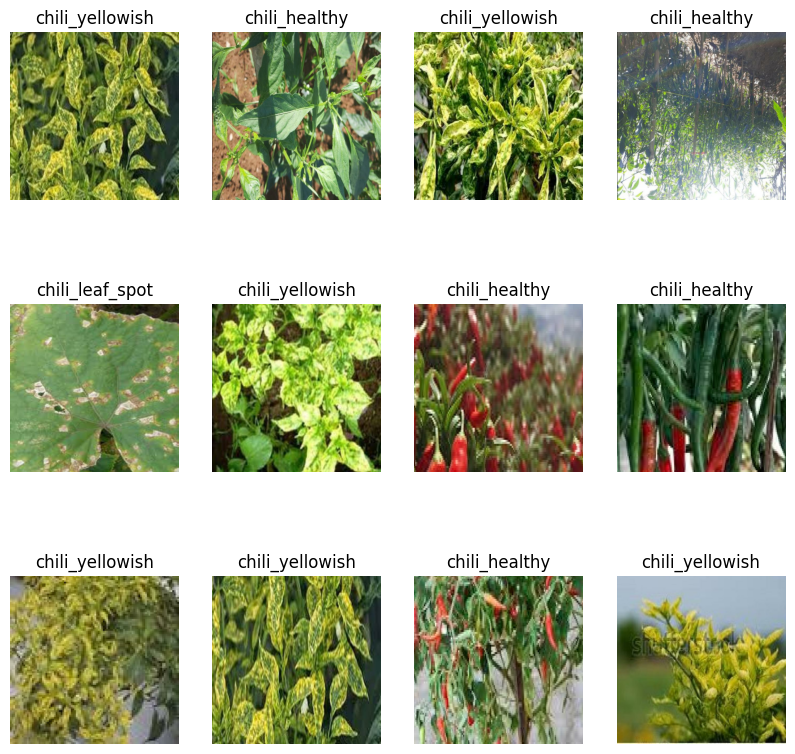

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

64

In [10]:
train_size = 0.8
len(dataset)*train_size

51.2

In [11]:
train_ds = dataset.take(51)
len(train_ds)

51

In [12]:
test_ds = dataset.skip(51)
len(test_ds)

13

In [13]:
val_size = 0.1
len(dataset)*val_size

6.4

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

7

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

51

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

7

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 640, 640, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 640, 640, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 638, 638, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 319, 319, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 317, 317, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 158, 158, 64)        0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


51/51 [==============================] - 329s 6s/step - loss: 1.2621 - accuracy: 0.4069 - val_loss: 0.9477 - val_accuracy: 0.5990
Epoch 2/50
51/51 [==============================] - 290s 6s/step - loss: 1.0746 - accuracy: 0.5092 - val_loss: 0.9321 - val_accuracy: 0.6042
Epoch 3/50
51/51 [==============================] - 272s 5s/step - loss: 0.9843 - accuracy: 0.5686 - val_loss: 0.8656 - val_accuracy: 0.6667
Epoch 4/50
51/51 [==============================] - 281s 5s/step - loss: 0.9724 - accuracy: 0.5760 - val_loss: 0.8823 - val_accuracy: 0.6302
Epoch 5/50
51/51 [==============================] - 277s 5s/step - loss: 0.8587 - accuracy: 0.6281 - val_loss: 0.8599 - val_accuracy: 0.6094
Epoch 6/50
51/51 [==============================] - 277s 5s/step - loss: 0.8355 - accuracy: 0.6520 - val_loss: 0.9167 - val_accuracy: 0.5990
Epoch 7/50
51/51 [==============================] - 281s 5s/step - loss: 0.8044 - accuracy: 0.6697 - val_loss: 0.9426 - val_accuracy: 0.6562
Epoch 8/50


In [29]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 43s 1s/step - loss: 0.1167 - accuracy: 0.9732


In [30]:
scores

[0.11671622842550278, 0.9732142686843872]

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 51}

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

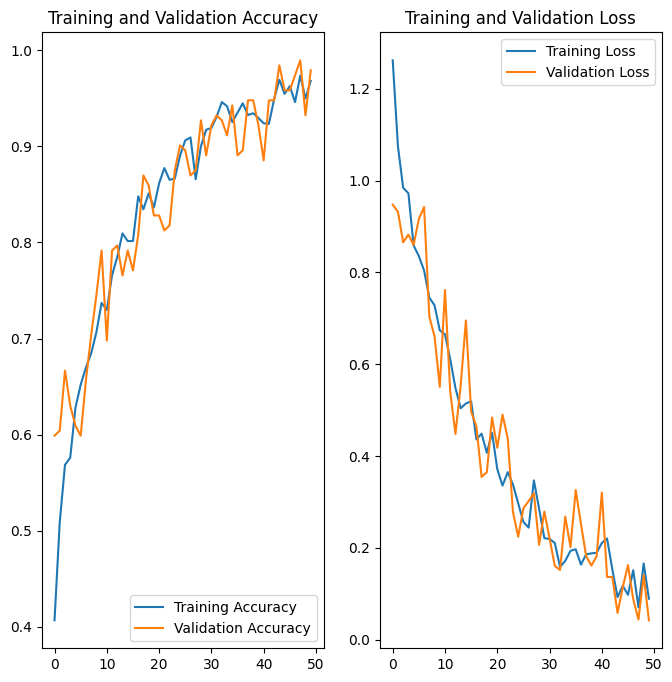

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

First image to predict
actual label: chili_whitefly
1/1 [==============================] - 1s 1s/step
predicted label: chili_whitefly


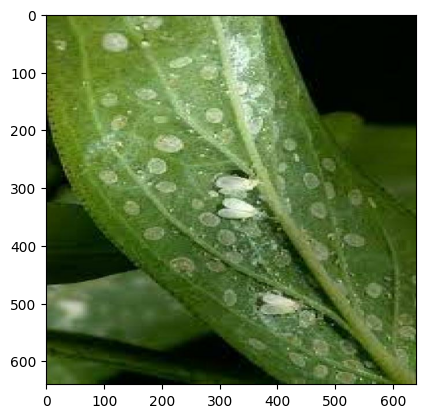

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print('actual label:',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 78ms/step


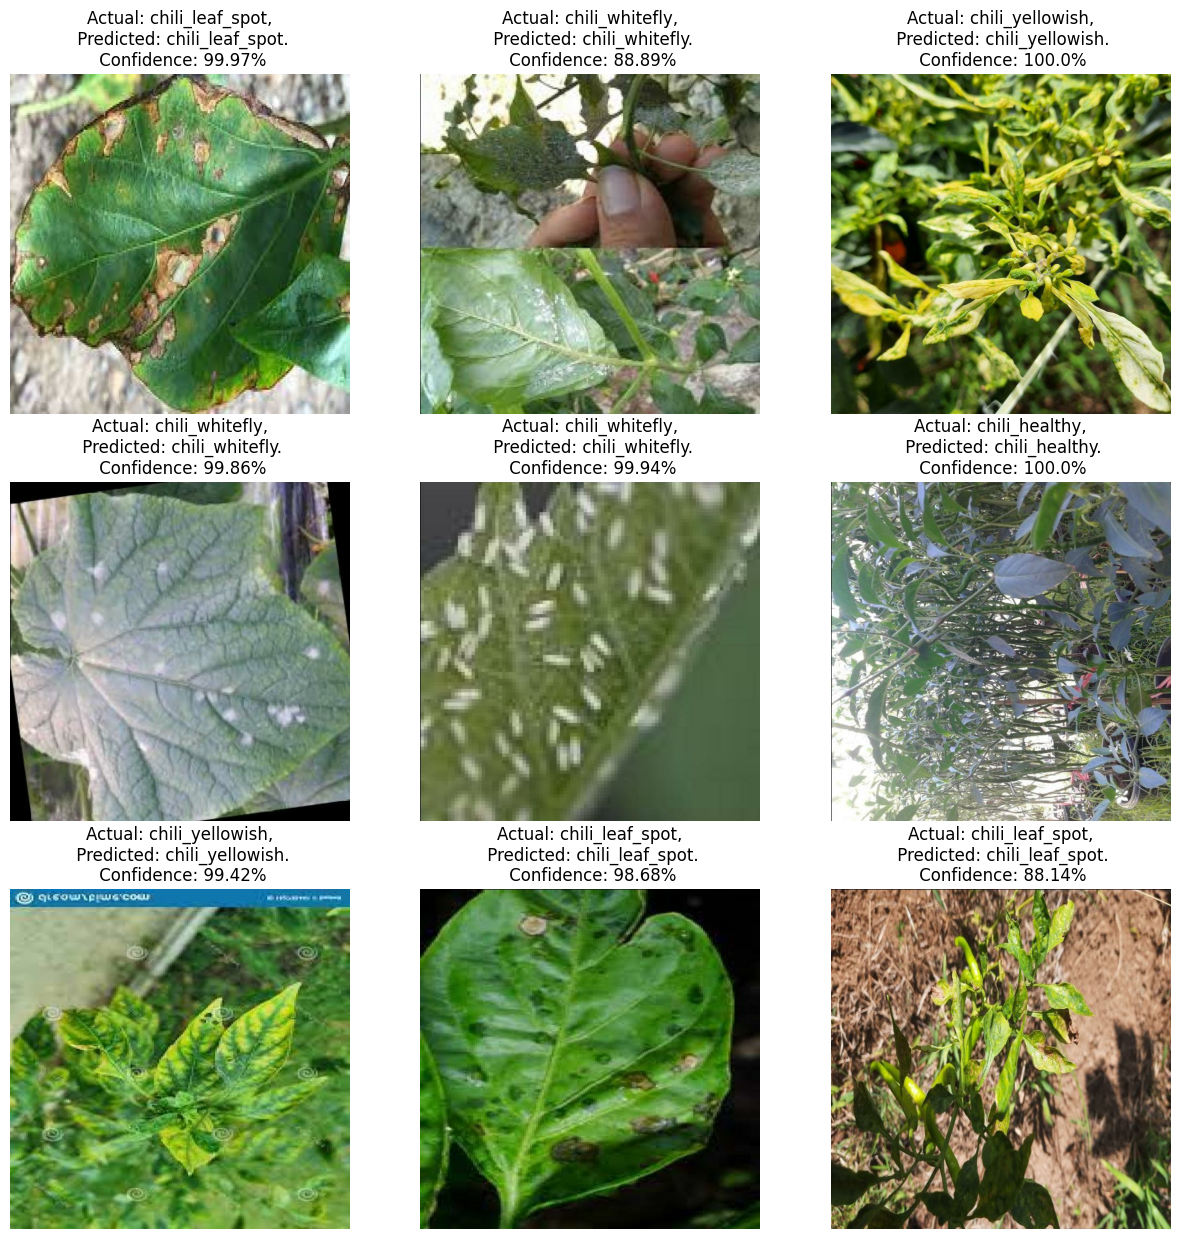

In [45]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%')
        plt.axis("off")

In [41]:
model.save('chili.keras')